In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import string
import textblob as tb
from tqdm import tqdm

### Exploring the data

In [2]:
colnames = ['title']
df = pd.read_csv('naver_title.csv', encoding='utf-8', header=None, names=colnames)

print(df.head())
print(len(df))

                                         title
0                            독이 된 황교안의 ‘가벼운 입’
1  “Fantastic Woman” 틈만 나면 김정숙 여사 특급 칭찬한 트럼프 …
2                              강효상 ‘빗나간 예측’ 망신
3      "민주당, 나경원 살리고 심상정 버렸다" 정의당 반발에… 與, 공조 …
4             탁현민 "준비안된 남북미 만남…인공기·성조기 바닥에 끌려"
300


In [3]:
df['title'].isnull().values.any()

False

### Data cleaning

In [4]:
# 자주쓰이는 한자 한국어로 변환

def change_string(x):
    return x.replace('靑','청와대').replace('軍','군대').replace('北','북한').replace('美','미국').replace('日','일본').replace('韓', '한국').replace('與', '여당').replace('野', '야당').replace('中', '중국').replace('黃', '황교안').replace('文', '문재인')

In [5]:
df['title'] = df['title'].map(lambda x : change_string(x))

In [6]:
news_title = []
news_title.extend(list(df.title.values)) # 헤드라인의 값들을 리스트로 저장

In [7]:
from string import punctuation
import re

def clean_text(text):
#     cleaned_text = [''.join(c for c in text).lower()]
#     cleaned_text = re.sub('[^가-힣a-zA-Z文 ]', '', text)
    cleaned_text = re.sub('[0-9]', ' ', text) # 숫자 공백으로 치환
    cleaned_text = re.sub('[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"\'\·]', # 특수문자 공백으로 치환
                          ' ', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text) # 다중 공백 하나의 공백으로 치환
    return cleaned_text

In [8]:
text = [clean_text(x) for x in news_title] # 특수문자, 숫자 제거
text = pd.DataFrame(text, columns=['title'])
text.head()

,title
0,독이 된 황교안의 ‘가벼운 입’
1,“Fantastic Woman” 틈만 나면 김정숙 여사 특급 칭찬한 트럼프 …
2,강효상 ‘빗나간 예측’ 망신
3,민주당 나경원 살리고 심상정 버렸다 정의당 반발에… 여당 공조 …
4,탁현민 준비안된 남북미 만남…인공기 성조기 바닥에 끌려


In [9]:
from konlpy.tag import Komoran

stopwords = set(['신문', '종합', '단독', '상보', '속보', '것', '내일']) # 불용어 추가
dicpath = 'user_dict.txt' 
komoran = Komoran(userdic=dicpath) # 사용자 사전 등록

text['title'] = text.apply(lambda row: komoran.nouns(row['title']), axis=1) # Komoran 형태소 분석기에서 명사로 인식되는 단어만 사용
text['title'] = text['title'].apply(lambda x: [word for word in x if word not in stopwords]) # 불용어 제거
text.head()

C:\ProgramData\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


,title
0,"[독, 황교안, 입]"
1,"[틈, 김정숙, 여사, 특급, 칭찬, 한, 트럼프]"
2,"[강효상, 예측, 망신]"
3,"[민주당, 나경원, 심상정, 정의당, 반발, 여당, 공조]"
4,"[탁현민, 준비, 안, 남북미, 만남, 인공, 성조기, 바닥]"


In [10]:
tokenized_doc = text['title'].apply(lambda x: [word for word in x if len(word) >1]) # 한 글자안 단어 제거
tokenized_doc.head()

0                               [황교안]
1              [김정숙, 여사, 특급, 칭찬, 트럼프]
2                       [강효상, 예측, 망신]
3    [민주당, 나경원, 심상정, 정의당, 반발, 여당, 공조]
4     [탁현민, 준비, 남북미, 만남, 인공, 성조기, 바닥]
Name: title, dtype: object

In [24]:
tokenized_doc = tokenized_doc[:30] # 30씩 끊어서 사용

In [11]:
# documents = [] 
# for i in range(len(text)): 
#     t = ' '.join(tokenized_doc[i]) # 역 토큰화
#     documents.append(t)
    
# documents[:5]

['황교안',
 '김정숙 여사 특급 칭찬 트럼프',
 '강효상 예측 망신',
 '민주당 나경원 심상정 정의당 반발 여당 공조',
 '탁현민 준비 남북미 만남 인공 성조기 바닥']

### LDA

In [12]:
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:33: DeprecationWarning: invalid escape sequence \d
  """


In [21]:
id2word = corpora.Dictionary(tokenized_doc)
corpus = [id2word.doc2bow(text) for text in tokenized_doc] # doc2bow: 단어-빈도수 list로 변환하는 함수
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]] # term-frequency의 정보 확인

[[('황교안', 1)],
 [('김정숙', 1), ('여사', 1), ('칭찬', 1), ('트럼프', 1), ('특급', 1)],
 [('강효상', 1), ('망신', 1), ('예측', 1)]]

In [20]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:/Users/{user_name}/mallet-2.0.8'

mallet_path = 'C:/Users/{user_name}/mallet-2.0.8/bin/mallet'

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tokenized_doc, start=1, limit=16, step=3)

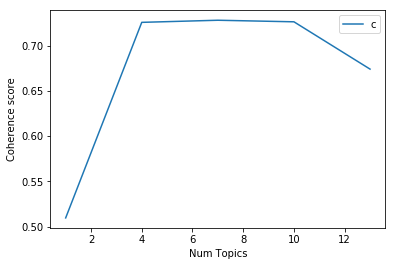

In [23]:
# Show graph
limit = 16; start=1; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [24]:
for m, cv in zip(x, coherence_values):
    print('Num Topics =', m, " has Coherence Value of", round(cv, 4)) # 최적의 topic 수 선택

Num Topics = 1  has Coherence Value of 0.5095
Num Topics = 4  has Coherence Value of 0.7259
Num Topics = 7  has Coherence Value of 0.7282
Num Topics = 10  has Coherence Value of 0.7265
Num Topics = 13  has Coherence Value of 0.6741


In [25]:
# # Select the model and print the topics
# optimal_model = model_list[3]
# model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

In [26]:
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=7, id2word=id2word)

# import gensim    
# mallet_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [27]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(mallet_model, corpus, id2word)
# vis

In [28]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=7,
                                           alpha='auto',
                                           per_word_topics=True)

In [29]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.041*"대통령" + 0.041*"사실상" + 0.041*"종식" + 0.041*"관계" + 0.023*"북미" + '
  '0.023*"문재인" + 0.023*"트럼프" + 0.023*"만남" + 0.023*"고대" + 0.023*"폭풍"'),
 (1,
  '0.049*"대통령" + 0.040*"문재인" + 0.031*"시대" + 0.021*"평화" + 0.021*"종식" + '
  '0.021*"서명" + 0.021*"행동" + 0.021*"시작" + 0.021*"언어" + 0.021*"없지"'),
 (2,
  '0.063*"황교안" + 0.053*"주자" + 0.053*"이낙연" + 0.053*"차기" + 0.053*"선호도" + '
  '0.033*"대선" + 0.023*"트럼프" + 0.023*"리얼미터" + 0.013*"북한" + 0.013*"추정"'),
 (3,
  '0.028*"사실상" + 0.028*"종전선언" + 0.028*"남북" + 0.028*"아베" + 0.016*"황교안" + '
  '0.016*"북미" + 0.016*"여야" + 0.016*"착수" + 0.016*"부대" + 0.016*"청문회"')]


In [30]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_doc, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.275212653449192

Coherence Score:  0.40592760458348454


In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.096828 -0.082437       1        1  35.087822
2     -0.158273 -0.030690       2        1  31.773514
3      0.027959  0.120018       3        1  22.694319
0      0.033486 -0.006891       4        1  10.444350, topic_info=    Category      Freq  Term     Total  loglift  logprob
34   Default  5.000000   대통령  5.000000  30.0000  30.0000
40   Default  2.000000    종식  2.000000  29.0000  29.0000
17   Default  3.000000    주자  3.000000  28.0000  28.0000
92   Default  3.000000   이낙연  3.000000  27.0000  27.0000
94   Default  3.000000    차기  3.000000  26.0000  26.0000
16   Default  3.000000   선호도  3.000000  25.0000  25.0000
63   Default  3.000000   사실상  3.000000  24.0000  24.0000
113  Default  1.000000    관계  1.000000  23.0000  23.0000
18   Default  5.000000   황교안  5.000000  22.0000  22.0000
14   Default  2.000000    대선  2.000000  21.0000  21.0000
86   Default  1.000000    남북  1.000000  20.0000  20.0000
2    Default  1.000000    아베  1.000000  19.0000  19.0000
56   Default  1.000000    만남  1.000000  18.0000  18.0000
55   Default  1.000000   김정은  1.000000  17.0000  17.0000
36   Default  1.000000    선언  1.000000  16.0000  16.0000
62   Default  2.000000    북미  2.000000  15.0000  15.0000
108  Default  0.000000    고대  0.000000  14.0000  14.0000
112  Default  0.000000    폭풍  0.000000  13.0000  13.0000
109  Default  0.000000    만나  0.000000  12.0000  12.0000
111  Default  0.000000    트윗  0.000000  11.0000  11.0000
110  Default  0.000000    보도  0.000000  10.0000  10.0000
61   Default  2.000000   트럼프  2.000000   9.0000   9.0000
125  Default  0.000000    보수  0.000000   8.0000   8.0000
126  Default  0.000000    진보  0.000000   7.0000   7.0000
37   Default  2.000000    시대  2.000000   6.0000   6.0000
67   Default  2.000000  종전선언  2.000000   5.0000   5.0000
20   Default  4.000000   문재인  4.000000   4.0000   4.0000
15   Default  1.000000  리얼미터  1.000000   3.0000   3.0000
35   Default  1.000000    서명  1.000000   2.0000   2.0000
42   Default  1.000000    행동  1.000000   1.0000   1.0000
..       ...       ...   ...       ...      ...      ...
34    Topic4  0.895470   대통령  5.379679   0.4661  -3.1840
61    Topic4  0.496555   트럼프  2.990916   0.4635  -3.7737
20    Topic4  0.498265   문재인  4.962432  -0.0394  -3.7702
100   Topic4  0.099370    해고  1.167914  -0.2050  -5.3825
30    Topic4  0.099363    대응  1.167919  -0.2051  -5.3826
98    Topic4  0.099362   심상정  1.167917  -0.2051  -5.3826
33    Topic4  0.099360    정부  1.167910  -0.2051  -5.3826
53    Topic4  0.099359    육군  1.167908  -0.2051  -5.3826
32    Topic4  0.099356    적극  1.167916  -0.2052  -5.3827
97    Topic4  0.099352   민주당  1.167917  -0.2052  -5.3827
72    Topic4  0.099351    준비  1.167908  -0.2052  -5.3827
47    Topic4  0.099351    공군  1.167915  -0.2052  -5.3827
1     Topic4  0.099349   반바지  1.167907  -0.2052  -5.3827
88    Topic4  0.099348    재개  1.167909  -0.2052  -5.3827
50    Topic4  0.099348   부사관  1.167908  -0.2052  -5.3827
89    Topic4  0.099348    협력  1.167910  -0.2052  -5.3827
6     Topic4  0.099348    차림  1.167916  -0.2052  -5.3827
64    Topic4  0.101825    성사  1.264372  -0.2600  -5.3581
65    Topic4  0.101413    언급  1.264672  -0.2643  -5.3622
66    Topic4  0.101063    인식  1.264922  -0.2679  -5.3656
94    Topic4  0.117440    차기  3.889065  -1.2409  -5.2154
16    Topic4  0.117422   선호도  3.889068  -1.2410  -5.2156
92    Topic4  0.117417   이낙연  3.889094  -1.2411  -5.2156
17    Topic4  0.117367    주자  3.889126  -1.2415  -5.2161
18    Topic4  0.115987   황교안  5.822872  -1.6570  -5.2279
67    Topic4  0.102001  종전선언  2.435081  -0.9136  -5.3564
37    Topic4  0.101156    시대  2.632211  -0.9998  -5.3647
31    Topic4  0.099474    삼성  1.831570  -0.6539  -5.3815
99    Topic4  0.099443   정의당  1.831685  -0.6543  -5.3818
19    Topic4  0.099421    만원  1.949776  -0.7170  -5.3820

[179 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
115   